In [2]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.8 MB/s eta 0:00:00


In [3]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import optuna
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import shapiro
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, f1_score , recall_score, precision_score, balanced_accuracy_score
warnings.filterwarnings('ignore')

In [4]:
data = pd.read_excel('/content/drive/MyDrive/task_from_Acba/Data.xlsx')

In [5]:
data

,loan_ID,start_date,req30_count,req_count,switch_class_q,max_risk_class,credit_history_max_overdue,loan_max_amount,current_loans_amount,received_loans_amount,total_repaid_amount,received_loans_count,bank_received_loans_count,uco_received_loans_count,current_loans_count,current_PMT,max_PMT,loan_history_total_overdue,current_overdue,max_overdue
0,507512,2019-12-06,1,8,14.0,4,828.0,705000,887224,2667068,1779844,7,5,2,3,52971,27912.0,81509.0,96.0,0
1,536188,2020-02-25,2,11,0.0,1,1.0,325000,252610,779000,526390,3,1,2,2,44420,30419.0,0.0,1.0,0
2,293370,2019-07-18,1,29,1.0,1,3.0,400000,565904,975900,409996,4,2,2,3,36850,71206.0,0.0,2.0,0
3,493684,2019-10-25,1,9,0.0,1,NaN,530000,155731,1742000,1586269,8,6,2,2,46996,33874.0,0.0,NaN,0
4,77225,2020-01-09,1,10,0.0,1,NaN,157000,27813,421900,394087,4,3,1,1,13012,23736.0,0.0,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8292,446069,2020-04-01,6,61,0.0,1,6.0,6719041,7850178,32907545,25057367,21,14,7,4,217839,172608.0,0.0,3.0,24
8293,311830,2020-01-24,1,8,1.0,1,12.0,3000000,3423576,12518700,9095124,15,12,3,3,167352,99742.0,0.0,4.0,0
8294,49101,2018-12-25,3,27,0.0,1,4.0,1433680,2329222,4865191,2535969,15,6,9,5,106174,65497.0,0.0,3.0,15
8295,41468,2018-12-27,3,12,0.0,1,NaN,393000,467329,932000,464671,3,0,3,2,23587,20130.0,0.0,NaN,0


We don't need **loan_ID** and **start_date** columns , we can delete

In [6]:
columns_to_drop = ['loan_ID', 'start_date']
data = data.drop(columns_to_drop, axis=1)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8297 entries, 0 to 8296
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   req30_count                 8297 non-null   int64  
 1   req_count                   8297 non-null   int64  
 2   switch_class_q              8294 non-null   float64
 3   max_risk_class              8297 non-null   object 
 4   credit_history_max_overdue  5056 non-null   float64
 5   loan_max_amount             8297 non-null   int64  
 6   current_loans_amount        8297 non-null   int64  
 7   received_loans_amount       8297 non-null   int64  
 8   total_repaid_amount         8297 non-null   int64  
 9   received_loans_count        8297 non-null   object 
 10  bank_received_loans_count   8297 non-null   int64  
 11  uco_received_loans_count    8297 non-null   int64  
 12  current_loans_count         8297 non-null   int64  
 13  current_PMT                 8297 

**received_loans_count** and **max_risk_class**  columns contain invalid values (their Dtype is object).

In [8]:
data['received_loans_count'] = pd.to_numeric(data['received_loans_count'], errors='coerce')
data['max_risk_class'] = pd.to_numeric(data['max_risk_class'], errors='coerce')

**We use missingno class for the visualization of Nan values**

<Axes: >

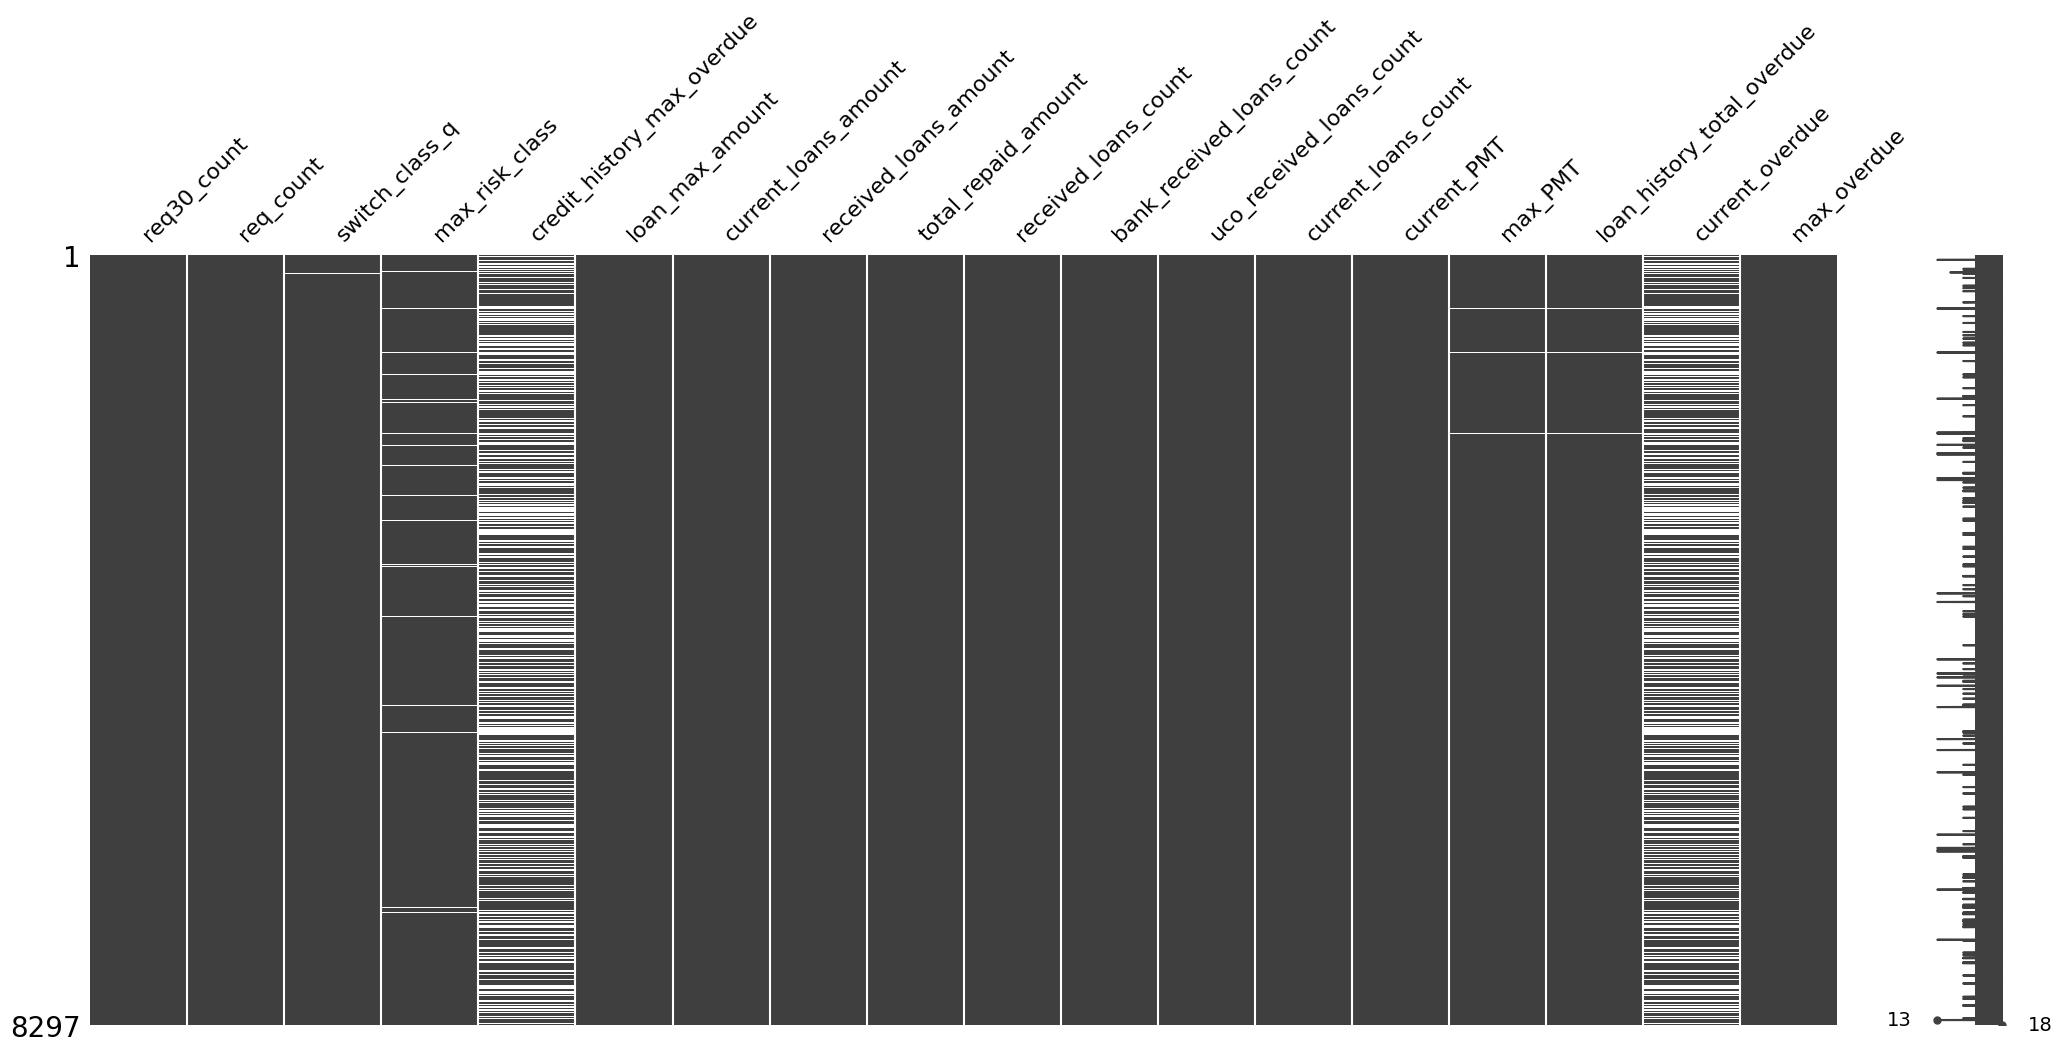

In [9]:
msno.matrix(data)

In [10]:
data.isna().sum()

,0
req30_count,0
req_count,0
switch_class_q,3
max_risk_class,220
credit_history_max_overdue,3241
loan_max_amount,0
current_loans_amount,0
received_loans_amount,0
total_repaid_amount,0
received_loans_count,1


In [11]:
credit_hist_not_na = data['credit_history_max_overdue'][~data['credit_history_max_overdue'].isna()]
curr_overdue_not_na = data['current_overdue'][~data['current_overdue'].isna()]

min_value_credit_hist = credit_hist_not_na.min()
min_value_curr_overdue = curr_overdue_not_na.min()
print(min_value_curr_overdue)
print(min_value_credit_hist)

1.0
0.0


In [12]:
count_min_min_value_credit_hist = (credit_hist_not_na == min_value_credit_hist).sum()
count_min_min_value_curr_overdue = (curr_overdue_not_na == min_value_curr_overdue).sum()
print(count_min_min_value_credit_hist)

1


**Credit_history_max_overdue contains only one 0 value and current_overdue columns don't have 0 values , instead Nans. I fill Nan values with 0 in these 2 columns, overdue is empty that means that customers has 0 overdue**

In [13]:
data['credit_history_max_overdue'] = data['credit_history_max_overdue'].fillna(0)
data['current_overdue'] = data['current_overdue'].fillna(0)

**Filling switch_class_q and max_risk_class with mode values**


In [14]:
data['switch_class_q'] = data['switch_class_q'].fillna(data['switch_class_q'].mode()[0])
data['max_risk_class'] = data['max_risk_class'].fillna(data['switch_class_q'].mode()[0])

In [17]:
data = data.dropna(axis=0)

**In this step I will check normality features' distributions by Shapiro-Wilk test**

In [19]:
def shapiro_test_for_columns(df):
    p_values = []
    for col in df.columns:
        stat, p = shapiro(df[col])
        p_values.append(p)
    p_values_df = pd.DataFrame({'Column': df.columns, 'p-value': p_values})
    return p_values_df

In [20]:
results = shapiro_test_for_columns(data)
print(results)

                        Column        p-value
0                  req30_count   1.080586e-83
1                    req_count   5.800364e-80
2               switch_class_q   6.385089e-94
3               max_risk_class  1.144077e-104
4   credit_history_max_overdue  3.522111e-106
5              loan_max_amount   1.930076e-99
6         current_loans_amount   6.946509e-89
7        received_loans_amount   8.941723e-92
8          total_repaid_amount   1.021744e-94
9         received_loans_count  1.068042e-109
10   bank_received_loans_count   4.219192e-67
11    uco_received_loans_count   1.348884e-77
12         current_loans_count  1.202475e-109
13                 current_PMT   2.825335e-79
14                     max_PMT   5.765932e-98
15  loan_history_total_overdue  4.565369e-109
16             current_overdue  5.366837e-108
17                 max_overdue  3.571321e-100


Results shows that distributions are not normal.
In the data we have many outliers that will be removed

**recieved_loans_count** , **current_loans_count**, **current_loans_amount** , **total_repaid_amount** , **current_PMT**, **max_PMT** , **loan_history_total_overdue** columns contain outliers
Esspecialy loan_history_total_overdue column contains million overdue days , which is impossible I guess




**Making  statistical test using interquartile range formula for droping that outliers**

In [21]:
def drop_outliers_multiple_columns(df, columns, factor=1.5):
  for column in columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - factor * IQR
    upper_bound = Q3 + factor * IQR
    df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
  return df

In [22]:
data_without_outliers = drop_outliers_multiple_columns(data, ['received_loans_count', 'current_loans_count', 'current_loans_amount',
                                                  'current_PMT', 'max_PMT'])

In [23]:
data_without_outliers

,req30_count,req_count,switch_class_q,max_risk_class,credit_history_max_overdue,loan_max_amount,current_loans_amount,received_loans_amount,total_repaid_amount,received_loans_count,bank_received_loans_count,uco_received_loans_count,current_loans_count,current_PMT,max_PMT,loan_history_total_overdue,current_overdue,max_overdue
0,1,8,14.0,4.0,828.0,705000,887224,2667068,1779844,7.0,5,2,3,52971,27912.0,81509.0,96.0,0
1,2,11,0.0,1.0,1.0,325000,252610,779000,526390,3.0,1,2,2,44420,30419.0,0.0,1.0,0
2,1,29,1.0,1.0,3.0,400000,565904,975900,409996,4.0,2,2,3,36850,71206.0,0.0,2.0,0
3,1,9,0.0,1.0,0.0,530000,155731,1742000,1586269,8.0,6,2,2,46996,33874.0,0.0,0.0,0
4,1,10,0.0,1.0,0.0,157000,27813,421900,394087,4.0,3,1,1,13012,23736.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8291,1,7,4.0,1.0,229.0,1200000,1102030,4365000,3262970,8.0,4,4,2,26070,52871.0,0.0,65.0,0
8293,1,8,1.0,1.0,12.0,3000000,3423576,12518700,9095124,15.0,12,3,3,167352,99742.0,0.0,4.0,0
8294,3,27,0.0,1.0,4.0,1433680,2329222,4865191,2535969,15.0,6,9,5,106174,65497.0,0.0,3.0,15
8295,3,12,0.0,1.0,0.0,393000,467329,932000,464671,3.0,0,3,2,23587,20130.0,0.0,0.0,0


**Spliting data into X and Y parts . Than we will split data into train and test**

In [24]:
target = data_without_outliers['max_overdue']

In [25]:
X = data_without_outliers.drop(['max_overdue'], axis=1)

In [27]:
y = target

In [28]:
y_actual_30 = pd.Series(list(map(lambda x: 1 if x >= 30 else 0, target)))
y_actual_60 = pd.Series(list(map(lambda x: 1 if x >= 60 else 0, target)))
y_actual_90 = pd.Series(list(map(lambda x: 1 if x >= 90 else 0, target)))

In [29]:
y_actual_30.value_counts()

,count
0,6106
1,730


In [30]:
y_actual_60.value_counts()

,count
0,6260
1,576


In [31]:
y_actual_90.value_counts()

,count
0,6310
1,526


In [33]:
X_train, X_test, y_train_30, y_test_30 = train_test_split(X, y_actual_30, test_size=0.2, random_state=42)

In [34]:
y_train_30.value_counts()

,count
0,4858
1,610


In [35]:
y_test_30.value_counts()

,count
0,1248
1,120


In [36]:
xgb = XGBClassifier()

On this step we calculate cross validation score for evaluation

In [43]:
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

**Evaluation of the model**

In [45]:
scores = cross_val_score(xgb, X_train, y_train_30, scoring='roc_auc', cv=cv, n_jobs=-1)

In [46]:
print('Mean ROC AUC: %.5f' % scores.mean())

Mean ROC AUC: 0.64495


Making optuna model for finding the best hyperparameters combination

In [48]:
def objective(trial):
    param = {
        "max_depth": trial.suggest_int("max_depth", 2, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 1.0),
        "gamma": trial.suggest_float("gamma", 0.0, 1.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0)
    }

    model = XGBClassifier(**param)
    score = cross_val_score(model, X_train, y_train_30, n_jobs=-1,scoring='roc_auc', cv=5).mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

print("Number of finished trials:", len(study.trials))
print("Best trial:", study.best_trial.params)
print("Best value:", study.best_value)

[I 2024-12-03 10:12:07,776] A new study created in memory with name: no-name-fd690118-6537-4cf3-94a0-84895091bc41
[I 2024-12-03 10:12:11,014] Trial 0 finished with value: 0.6344958547246107 and parameters: {'max_depth': 9, 'learning_rate': 0.2901584610625489, 'n_estimators': 316, 'reg_alpha': 0.8519518844031483, 'reg_lambda': 0.39795154097306207, 'gamma': 0.7672418677831185, 'scale_pos_weight': 9.3432839693923}. Best is trial 0 with value: 0.6344958547246107.
[I 2024-12-03 10:12:12,038] Trial 1 finished with value: 0.6553671566850664 and parameters: {'max_depth': 10, 'learning_rate': 0.22426410396986948, 'n_estimators': 83, 'reg_alpha': 0.8726821598613926, 'reg_lambda': 0.46912005551328995, 'gamma': 0.7471684219275793, 'scale_pos_weight': 6.346847770303811}. Best is trial 1 with value: 0.6553671566850664.
[I 2024-12-03 10:12:12,806] Trial 2 finished with value: 0.6657737460634873 and parameters: {'max_depth': 2, 'learning_rate': 0.20406236608096212, 'n_estimators': 240, 'reg_alpha': 0.

Number of finished trials: 100
Best trial: {'max_depth': 2, 'learning_rate': 0.020223444309939838, 'n_estimators': 356, 'reg_alpha': 0.47078960828723654, 'reg_lambda': 0.6575045007959628, 'gamma': 0.41616830724451886, 'scale_pos_weight': 1.3689445809108907}
Best value: 0.7125913274059232


In [49]:
best_optuna_params = study.best_trial.params

In [50]:
best_optuna_params

{'max_depth': 2,
 'learning_rate': 0.020223444309939838,
 'n_estimators': 356,
 'reg_alpha': 0.47078960828723654,
 'reg_lambda': 0.6575045007959628,
 'gamma': 0.41616830724451886,
 'scale_pos_weight': 1.3689445809108907}

In [51]:
model = XGBClassifier(**best_optuna_params)

In [52]:
model.fit(X_train, y_train_30)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.41616830724451886, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.020223444309939838,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=356, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [53]:
y_pred = model.predict(X_test)

In [54]:
print(confusion_matrix(y_test_30, y_pred))

[[1248    0]
 [ 118    2]]


Calculatig financial impact (0.7 LGD (loss given default) if true pos -> no loass from loan classification ,  -0.2 potential income not earned for false pos)

In [84]:
y_pred_prob = model.predict_proba(X_test)
def financial_result(y_pred_prob,y_test, threshold):
  y_pred = (y_pred_prob >= threshold).astype(int)
  conf_mat = confusion_matrix(y_test, y_pred)
  result = (conf_mat[1,1]*0.7 - conf_mat[0,1]*0.2)
  return result

In [87]:
fin_res = [financial_result(y_pred_prob[:,1],y_test_30, x) for x in np.arange(0.1,1.01,0.01)]

**Ploting optimal treshold**

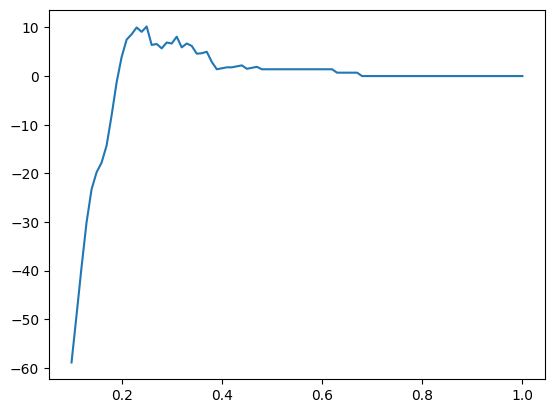

In [89]:
plt.plot(np.arange(0.1,1.01,0.01),fin_res)

 Optimal threshold can be chosen from 0.2-0.3 interval, where **net** financial impact is positive

In [95]:
opt_index = np.argmax(fin_res)

In [97]:
opt_threshold = list(np.arange(0.1,1.01,0.01))[opt_index]
opt_threshold

0.24999999999999992

In [99]:
y_pred_prob = model.predict_proba(X_test)
y_pred_opt = (y_pred_prob[:,1]>=opt_threshold).astype(int)

In [100]:
print(confusion_matrix(y_test_30, y_pred_opt))

[[1124  124]
 [  70   50]]


Saving the model


In [102]:
import pickle

In [103]:
with open('credit_model.pkl', 'wb') as file:
    pickle.dump(model, file)